In [25]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import datetime
import requests
import matplotlib.pyplot as plt
import time
import json

from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [42]:
PATH_TO_SENT_DATA = '../../data/sentiment_data.csv'
SLEEP_DURATION = 7
API_KEY = '&api-key=INSERT_KEY_HERE'

In [72]:
sent_data = pd.read_csv(PATH_TO_SENT_DATA)
sent_data['Date'] = pd.to_datetime(sent_data['Date'])
sent_data.tail()

,Date,pos,neg,neu,compound
7965,2022-01-14,0.078385,0.054038,0.867654,0.140962
7966,2022-01-15,0.030200,0.114800,0.855200,-0.392540
7967,2022-01-16,0.016000,0.086000,0.898333,-0.258533
7968,2022-01-17,0.079100,0.067800,0.853200,0.003590
7969,2022-01-18,0.062056,0.051444,0.886500,0.076989


In [27]:
def find_news_articles(begindate, nytimes_section, api_key):
    base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?'
    facet_str = f'&facet=true&begin_date={begindate}&end_date={begindate}'
    
    page = 0
    count = 0
    
    ret_list = []
    while True:
        url = base_url+nytimes_section+facet_str+f'&page={page}'+api_key
        r = requests.get(url)
        if r.status_code != 200:
            print(r.status_code)
        data = json.loads(r.content)
        time.sleep(SLEEP_DURATION)
        if page == 0:
            tot_articles = data['response']['meta']['hits']
            print(begindate, nytimes_section, 'tot_articles', tot_articles)
        for i, doc in enumerate(data['response']['docs']):
            ret_list.append((doc['headline']['main'], doc['lead_paragraph'], doc['web_url']))
            count += 1
        if count >= tot_articles:
            break
        page += 1
    #print(len(ret_list))
    return ret_list


In [58]:
begin_date = sent_data.iloc[-1]['Date'] + datetime.timedelta(days=1)
today = datetime.datetime.today()

print(begin_date, today)

daily_sentiment = defaultdict(defaultdict)
sid_obj = SentimentIntensityAnalyzer()

while begin_date <= today:

    days_sentiment_pos, days_sentiment_neg, days_sentiment_neu, days_sentiment_comp = 0, 0, 0, 0
    date_str = str(begin_date.year) + str(begin_date.month).zfill(2) + str(begin_date.day).zfill(2)

    news_desk_str = 'fq=news_desk:("Financial" "Business" "Business Day")'
    section_str = 'fq=section_name:("Your Money" "Business" "Business Day")'

    news_desk_list = find_news_articles(date_str, news_desk_str, API_KEY)
    section_list = find_news_articles(date_str, section_str, API_KEY)

    final_urls = set()
    for news in news_desk_list: # tuple of 3: headline, lead_paragraph, web_url
        if news[2] not in final_urls:
            # print('adding news desk article', news[0])
            final_urls.add(news[2])
            sentiment_dict = sid_obj.polarity_scores(news[0] + news[1])
            days_sentiment_pos += sentiment_dict['pos']
            days_sentiment_neg += sentiment_dict['neg']
            days_sentiment_neu += sentiment_dict['neu']
            days_sentiment_comp += sentiment_dict['compound']
    for news in section_list: # tuple of 3: headline, lead_paragraph, web_url
        if news[2] not in final_urls:
            # print('adding section article', news[0])
            final_urls.add(news[2])
            sentiment_dict = sid_obj.polarity_scores(news[0] + news[1])
            days_sentiment_pos += sentiment_dict['pos']
            days_sentiment_neg += sentiment_dict['neg']
            days_sentiment_neu += sentiment_dict['neu']
            days_sentiment_comp += sentiment_dict['compound']

    num_news_items = len(final_urls)
    if num_news_items > 0:
        daily_sentiment[date_str]['pos'] = days_sentiment_pos/num_news_items
        daily_sentiment[date_str]['neg'] = days_sentiment_neg/num_news_items
        daily_sentiment[date_str]['neu'] = days_sentiment_neu/num_news_items
        daily_sentiment[date_str]['compound'] = days_sentiment_comp/num_news_items
    else:
        daily_sentiment[date_str]['pos'] = 0
        daily_sentiment[date_str]['neg'] = 0
        daily_sentiment[date_str]['neu'] = 0
        daily_sentiment[date_str]['compound'] = 0
    begin_date += datetime.timedelta(days=1)

2022-01-19 00:00:00 2022-01-26 16:31:13.270846


In [73]:
new_df = pd.DataFrame(daily_sentiment).T
new_df.reset_index(inplace=True)
new_df.rename(columns={'index' : 'Date'}, inplace=True)
new_df['Date'] = pd.to_datetime(new_df['Date'], format="%Y%m%d")
new_df = pd.concat([sent_data, new_df], axis=0, ignore_index=True)

new_df.to_csv(PATH_TO_SENT_DATA, index=False)
sent_data = pd.read_csv(PATH_TO_SENT_DATA)
sent_data['Date'] = pd.to_datetime(sent_data['Date'])
sent_data.tail()


,Date,pos,neg,neu,compound
7973,2022-01-22,0.057429,0.047143,0.895429,0.040214
7974,2022-01-23,0.038800,0.100400,0.861000,-0.166620
7975,2022-01-24,0.076778,0.082889,0.840444,-0.034278
7976,2022-01-25,0.068125,0.075208,0.856625,-0.051667
7977,2022-01-26,0.069050,0.051850,0.879150,0.094505


0.10534315003697681

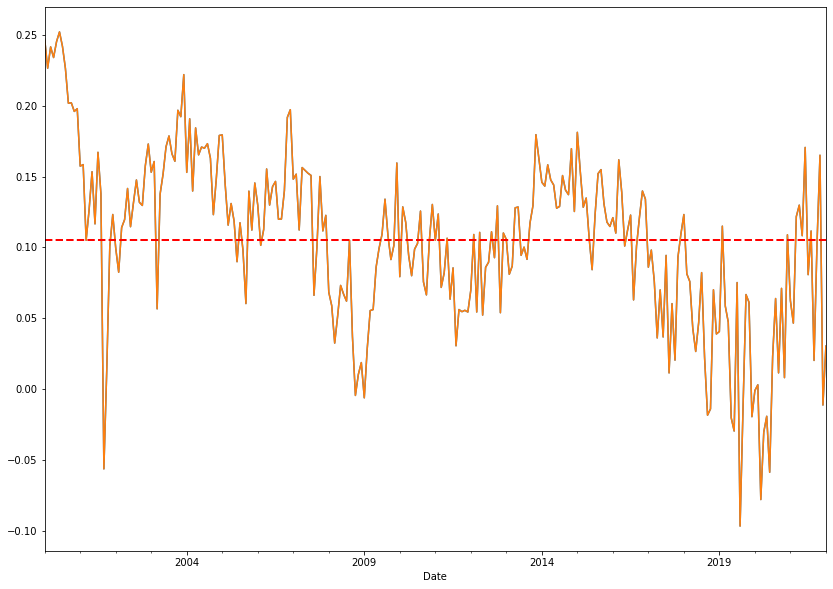

In [74]:
sent_data = pd.read_csv(PATH_TO_SENT_DATA)
sent_data['Date'] = pd.to_datetime(sent_data['Date'])
sent_data.tail()

monthly = sent_data.groupby(pd.PeriodIndex(sent_data['Date'], freq="M"))['compound'].mean()
monthly.plot(figsize=(14,10));
ax = monthly.plot.line()
ax.axhline(y=monthly.mean(), color='r', linestyle='--', lw=2)
monthly.mean()